In [148]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from collections import defaultdict
from sklearn import linear_model
import statsmodels.api as sm
import statsmodels.formula.api as smf
import math
from scipy.optimize import minimize
import os



## Load DataFrame, exclude low intensity samples
This notebook was optimized for max intensity data stored in `peak_max_df.csv`. You may also analyze the AUC data in `peak_auc_df.csv` but some plots may not look great and the axes need to be changed.

In [149]:
# specify an intensity threshold to use for fitting models; 
# if the mean intensity across both trials of an odor is smaller than this value, it gets excluded
# changing thisvalue doesn't really affect results
intensity_thresh = 0.000

df = pd.read_csv("/Volumes/mcbride/bjarnold/whole_AL_segmentation/results/peak_max_df.csv")
samples_to_exclude = ['230913_FCV_GCaMP6f_F1']
df = df[df.samp.isin(samples_to_exclude) == False].reset_index(drop=True)

df.loc[df.trial == 2, 'odor_order'] = df.loc[df.trial == 2, 'odor_order'] + 36
assert df.odor_order.nunique() == 72, f"number unique odors is {df.odor_order.nunique()}"
assert np.max(df.odor_order) == 71, f"max odor order is {np.max(df.odor_order)}"

print(f'Number of samples: {len(df.samp.unique())}')




Number of samples: 14


### Functions for linear regression
change `linear_regression` variable to change whether regular linear regression is done or Huber regression that is less sensitive to outliers

In [150]:
def reshape_X_Y(X,Y):
    X = np.array(X).reshape(-1,1)
    Y = np.array(Y).reshape(-1,1)
    return X,Y

def fit_linear_model_skl(X,Y):
    reg = linear_model.LinearRegression()
    Xr, Yr = reshape_X_Y(X,Y) # make each element a list, normally a list used if multiple features used
    reg.fit(Xr, Yr)
    return reg.coef_[0][0], reg.intercept_[0]

def fit_linear_model_huber_skl(X,Y):
    reg = linear_model.HuberRegressor()
    Xr, Yr = reshape_X_Y(X,Y) # make each element a list, normally a list used if multiple features used
    reg.fit(Xr, Yr.ravel()) # gave it .ravel() to avoid warning
    print(reg.coef_[0], reg.intercept_)
    return reg.coef_[0], reg.intercept_

linear_regression = fit_linear_model_skl

## Compare signal intensity of trial 1 vs. trial 2

- Comparing trial 1 vs trial 2 for each odor, which are 37 time steps apart, shows signal intensity decays by some multiplicative factor throughout the experiment
- Some subpopulations exhibit more decay
- Individual samples vary in signal decay


subpop ORL coef: 0.7879977406573127
subpop ORL intercept: 0.00054484116556859
subpop U52 coef: 0.5186004001771217
subpop U52 intercept: 0.0001871643948644702
subpop FCV coef: 0.5327293156153347
subpop FCV intercept: 0.00019970107787778673


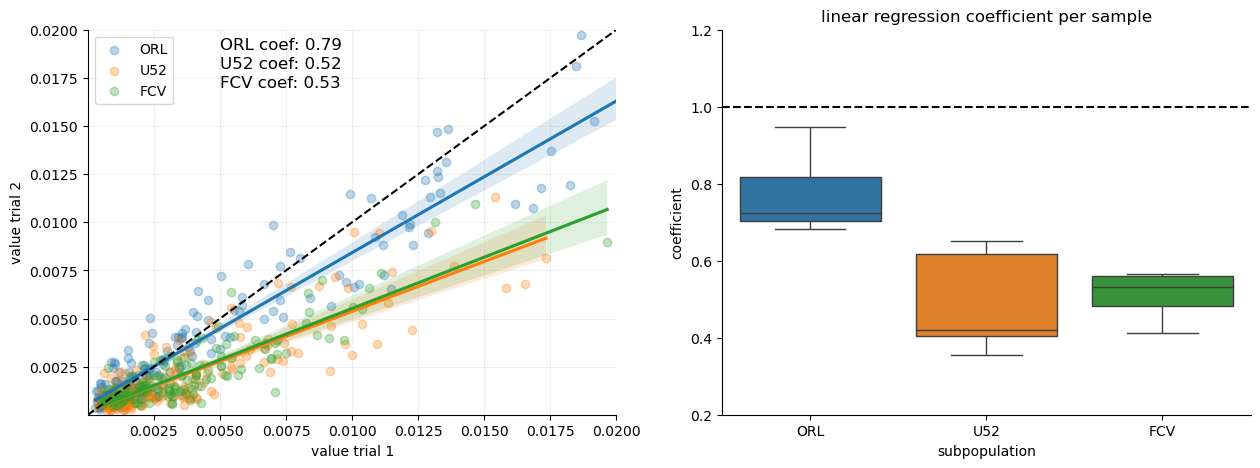

In [151]:
# dictionaries for storing slopes by subpopulation and sample
LM_subpop_slopes = defaultdict(float)
LM_samp_slopes = defaultdict(float)

def select_higher_intensity_odors(X, Y, intensity_thresh):
    # find indices in panas series X and Y with mean intensity greater than intensity_thresh
    select_indices = np.where((X+Y)/2 > intensity_thresh)
    X = X.iloc[select_indices]
    Y = Y.iloc[select_indices]
    return X, Y, select_indices

# Plot trends for each subpopulation
fig, axs = plt.subplots(1, 2, figsize=(15,5))
for i,subpop in enumerate(df.subpop.unique()):
    # X = np.array((df[(df.trial==1) & (df.subpop == subpop)]['value']))
    # Y = np.array((df[(df.trial==2) & (df.subpop == subpop)]['value']))
    # only select odors that have a mean value, across both trials, greater than the intensity threshold
    # X, Y = select_higher_intensity_odors(X, Y, intensity_thresh)

    X = df[(df.trial==1) & (df.subpop == subpop)]['value'].reset_index(drop=True)
    Y = df[(df.trial==2) & (df.subpop == subpop)]['value'].reset_index(drop=True)
    X, Y, _ = select_higher_intensity_odors(X, Y, intensity_thresh)
    sns.regplot(x=X,
                y=Y,
                label=subpop,
                scatter_kws={'alpha':0.3},
                ax=axs[0])

    # fit a linear model
    coef, intercept = linear_regression(X,Y)
    LM_subpop_slopes[subpop] = coef
    
    print(f'subpop {subpop} coef:', coef)
    print(f'subpop {subpop} intercept:', intercept)
    axs[0].text(0.005, 0.019-i*0.001, f'{subpop} coef: {coef:.2f}', fontsize=12)

axs[0].set_xlabel('value trial 1')
axs[0].set_ylabel('value trial 2')
axs[0].set_xlim(0.00001,0.02)
axs[0].set_ylim(0.00001,0.02)
axs[0].legend(loc='upper left')
# add x=y line to axs[0]
axs[0].plot([0,1],[0,1], color='black', linestyle='--')
axs[0].grid(True, alpha=0.2)


# Plot linear regression coefficients for each sample
reg_fits = defaultdict(list)
for i,samp in enumerate(df.samp.unique()):
    subpop = df[df.samp == samp].subpop.unique()[0]
    X = list(df[(df.trial==1) & (df.samp == samp)]['value'])
    Y = list(df[(df.trial==2) & (df.samp == samp)]['value'])

    # fit a linear model
    coef, intercept = linear_regression(X,Y)
    LM_samp_slopes[samp] = coef
    reg_fits['subpop'].append(subpop)
    reg_fits['coef'].append(coef)

reg_fits_df = pd.DataFrame(reg_fits)
sns.boxplot(data=reg_fits_df, x='subpop', y='coef', ax=axs[1], hue='subpop')
axs[1].set_ylabel('coefficient')
axs[1].set_xlabel('subpopulation')
axs[1].set_title('linear regression coefficient per sample')
axs[1].set_ylim(0.2,1.2)
axs[1].axhline(y=1, color='black', linestyle='--')
sns.despine()

### Analyze decay in signal intentiry of trial 1 vs. trial 2 over time
- inspecting each odor in the order they occur suggests signal decay is relatively constant throughout experiment; i.e. the decay in signal intensity between the 1st and 2nd trial for the first odor seems similar to the last odor
- this again suggests signal decay by some constant multiplicative factor

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


subpop ORL coef: -0.007643435666054002
subpop ORL intercept: 1.2355465018177376

subpop U52 coef: 0.001833818493944517
subpop U52 intercept: 0.6283736037776504

subpop FCV coef: 0.004838808296803537
subpop FCV intercept: 0.5916559922901241



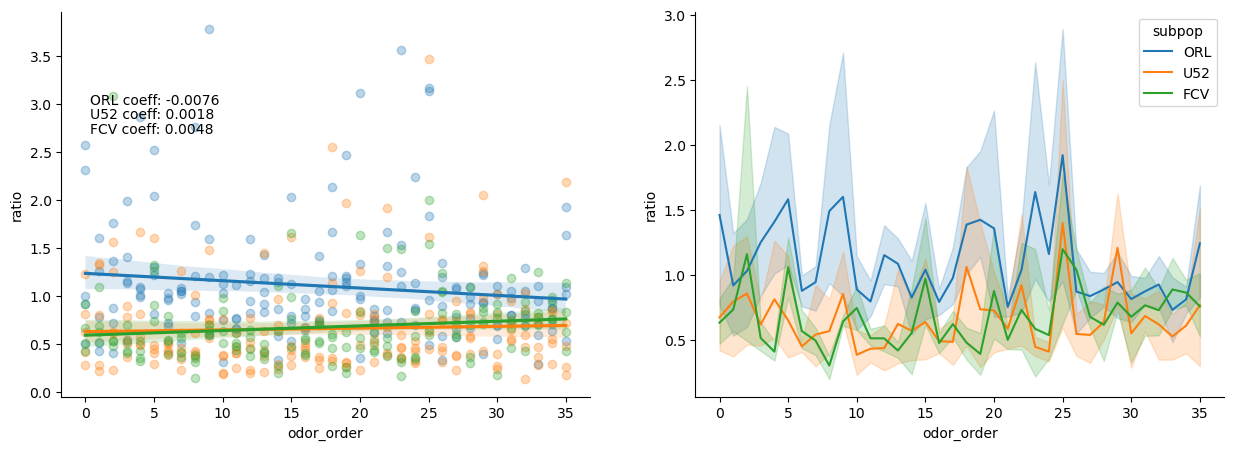

In [152]:
# go through dataframe, calculate ratio in signal intensity between trial 1 and trial 2 for each odor, keeping track of odor order and subpop
ratios = defaultdict(list)
for samp in df.samp.unique():
    tmp = df[df.samp==samp].reset_index(drop=True)
    
    tmp1 = tmp[tmp.trial==1].sort_values('odor_order').reset_index(drop=True)
    tmp2 = tmp[tmp.trial==2].sort_values('odor_order').reset_index(drop=True)

    odor_value_1, odor_value_2, indices = select_higher_intensity_odors(tmp1.value, tmp2.value, intensity_thresh)

    ratio = odor_value_2/odor_value_1
    subpop = tmp.subpop.unique()[0]

    ratios['ratio'].extend(ratio)
    ratios['subpop'].extend([subpop]*len(ratio))
    ratios['samp'].extend([samp]*len(ratio))
    ratios['odor'].extend(tmp1.iloc[indices].odor)
    ratios['odor_order'].extend(tmp1.iloc[indices].odor_order)
    ratios['avg'].extend((odor_value_1 + odor_value_2)/2)
ratios_df = pd.DataFrame(ratios)

fig, axs = plt.subplots(1, 2, figsize=(15,5))
# plot ratios over time
for i,subpop in enumerate(ratios_df.subpop.unique()):
    X = ratios_df[(ratios_df.subpop == subpop)]['odor_order']
    Y = ratios_df[(ratios_df.subpop == subpop)]['ratio']
    sns.regplot(x=X,
                y=Y,
                label=subpop,
                # lowess=True,
                scatter_kws={'alpha':0.3},
                ax=axs[0])
    coef, intercept = linear_regression(X,Y)
    
    print(f'subpop {subpop} coef:', coef)
    print(f'subpop {subpop} intercept:', intercept)
    axs[0].text(0.3, 3-i*0.15, f"{subpop} coeff: {coef:.4f}")
    print()
plt.legend(loc='upper left')

sns.lineplot(x='odor_order', y='ratio', hue='subpop', data=ratios_df, ax=axs[1])

sns.despine()

## Fitting exponential decay function to detrend decay in signal

The decay in signal intensity over time by some constant multiplicative factor can be modeled as exponential decay:

$$odor_{2} = odor_{1}*e^{-\lambda t}$$

Where
- $odor_{1}$ and $odor_{2}$ are the signal intensities of the first and second odor puffs (or trials), respectively
-  $\lambda$ is the decay rate that we will learn from the data, one for each sample
- $t$ is the time step, which will for this experiment will be 37 since a panel of 36 ordered odors was delivered twice such that duplicate odors are 37 time steps apart. We will only measure the rate of decay for these duplicate odors since we expect them to be the same in the absence of exponential signal decay. Thus, we only get an estimates of the decay rate separated by 37 time steps, but we get 36 different estimates of it, one for each odor.

If we fit a model of exponential decay to each sample, we can use the rate of decay to 'correct' or 'detrend' the data for each time step to account for signal decay at each point in the experiment.

To find the rate $\lambda$ that best fits the observed data for a particular sample, we solve the following optimization problem using `scipy.optimize.minimize`:

$$\underset{\lambda}{\operatorname{argmin}} \sum_{i=1}^{36} (odor_{i,2} - odor_{i,1}*e^{-\lambda 37})^2$$




In [157]:
# define the objective function to be minimized by the optimizer
def objective(x, first_puffs, second_puffs, time_step):
    # exponential decay
    predicted_vals = first_puffs * np.exp(-x * time_step)
    # print(np.sum((predicted_vals - second_puffs) ** 2))
    resid = (second_puffs - predicted_vals)**2
    loss = np.sum(resid)
    return loss

# specify a dictionary to store the exponential rate estimates
exponential_estimates = {}

initial_guess = 0.01
time_step = 37
for i,samp in enumerate(df.samp.unique()):
    subpop = df[df.samp == samp].subpop.unique()[0]
    first_puffs = df[(df.trial==1) & (df.samp == samp)]['value'].reset_index(drop=True)
    second_puffs = df[(df.trial==2) & (df.samp == samp)]['value'].reset_index(drop=True)
    first_puffs, second_puffs, _ = select_higher_intensity_odors(first_puffs, second_puffs, intensity_thresh)
    first_puffs, second_puffs = np.array(first_puffs), np.array(second_puffs)
    assert len(first_puffs) == len(second_puffs)
    # Optimize
    result = minimize(
        objective,
        initial_guess,
        args=(first_puffs, second_puffs, time_step,),
        method='Nelder-Mead')
    # print("scipy minimize:", result.x[0])
    exponential_estimates[samp] = result.x[0]


## Use estimates of exponential decay rates to detrend the data

In [154]:
values_corrected = []
for i,r in df.iterrows():
    rate = exponential_estimates[r.samp]
    time_point = r.odor_order
    correction_factor = np.exp(rate*time_point)
    val_corrected = (r.value)*correction_factor
    values_corrected.append(val_corrected)
df['value_detrended'] = values_corrected

subpop ORL coef: [[0.95742029]]
subpop ORL intercept: [0.00048981]
subpop U52 coef: [[1.01111697]]
subpop U52 intercept: [0.0001465]
subpop FCV coef: [[0.9875776]]
subpop FCV intercept: [0.00029553]


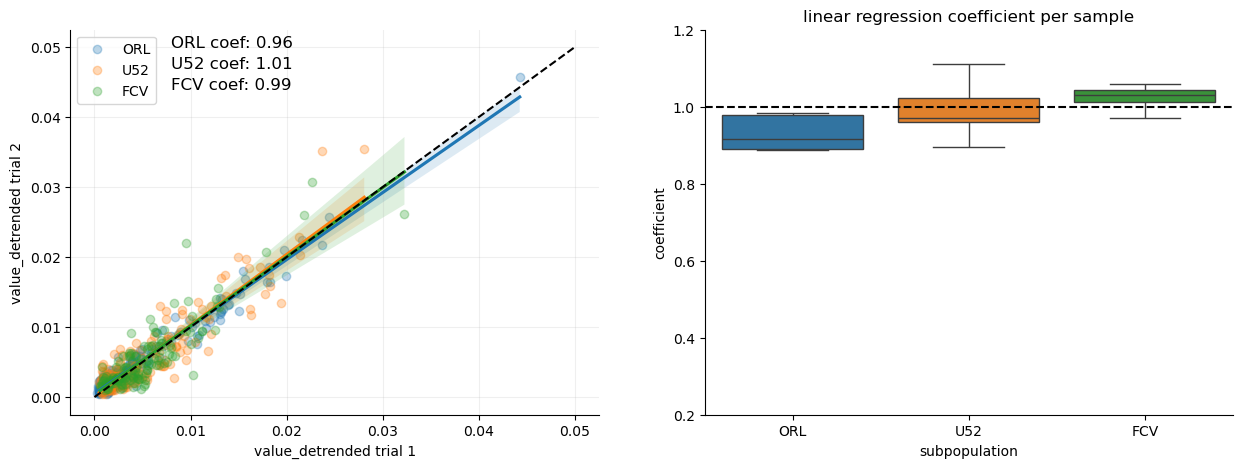

In [155]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
for i,subpop in enumerate(df.subpop.unique()):
    X = list(df[(df.trial==1) & (df.subpop == subpop)]['value_detrended'])
    Y = list(df[(df.trial==2) & (df.subpop == subpop)]['value_detrended'])
    sns.regplot(x=X,
                y=Y,
                label=subpop,
                scatter_kws={'alpha':0.3},
                ax=axs[0])

    # fit a linear model
    reg = linear_model.LinearRegression()
    Xr = np.array(X).reshape(-1,1) # make each element a list, normally a list used if multiple features used
    Yr = np.array(Y).reshape(-1,1)
    reg.fit(Xr, Yr)
    print(f'subpop {subpop} coef:', reg.coef_)
    print(f'subpop {subpop} intercept:', reg.intercept_)
    # print the re.coef_ value to axs[0]
    axs[0].text(0.008, 0.05-i*0.003, f'{subpop} coef: {reg.coef_[0][0]:.2f}', fontsize=12)


axs[0].set_xlabel('value_detrended trial 1')
axs[0].set_ylabel('value_detrended trial 2')
# create legend to label the regression lines that has the same colors as the subpopulations
axs[0].legend(loc='upper left')
# plot the correlation between the two trials and print this in the upper left corner
axs[0].plot([0,0.05],[0,0.05], color='black', linestyle='--')
# add grid lines 
axs[0].grid(True, alpha=0.2)


reg_fits = defaultdict(list)
for i,samp in enumerate(df.samp.unique()):
    subpop = df[df.samp == samp].subpop.unique()[0]
    X = list(df[(df.trial==1) & (df.samp == samp)]['value_detrended'])
    Y = list(df[(df.trial==2) & (df.samp == samp)]['value_detrended'])

    # fit a linear model
    coef, _ = linear_regression(X,Y)
    reg_fits['subpop'].append(subpop)
    reg_fits['coef'].append(coef)

reg_fits_df = pd.DataFrame(reg_fits)
sns.boxplot(data=reg_fits_df, x='subpop', y='coef', hue='subpop', ax=axs[1])
axs[1].set_ylabel('coefficient')
axs[1].set_xlabel('subpopulation')
axs[1].set_title('linear regression coefficient per sample')
axs[1].set_ylim(0.2,1.2)
axs[1].axhline(y=1, color='black', linestyle='--')

sns.despine()

## Save the results

In [156]:
os.makedirs('results_detrended', exist_ok=True)
df.to_csv('results_detrended/peak_max_df.csv', index=False)